## EE541 Project: Musical Chord Classification
## Author(s): Khaled Alrashidi, Khushboo Khatri
## Date: December 2, 2023

### --------------------------------------------------------------------------------------------
### Import necessary libraries

In [61]:
# for interacting with the operating system.
import os
# for audio and music analysis. It has tools for audio analysis and feature extraction.
import librosa
# for data manipulation and analysis
import pandas as pd
# for numerical computing 
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for data visualization
import seaborn as sns

# for working with audio files, specifically reading and writing WAV files
from scipy.io import wavfile
# for computing fast Fourier transforms
from scipy.fft import fft, fftfreq
# signal processing module to identify peaks in data
from scipy.signal import find_peaks

# for performing logistic regression
from sklearn.linear_model import LogisticRegression
# for creating a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
# for a multi-layer perceptron (MLP) classifier
from sklearn.neural_network import MLPClassifier
# for scaling features in data preprocessing
from sklearn.preprocessing import StandardScaler
# for various metric functions to measure the performance of a machine learning model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, log_loss
# for splitting datasets, cross-validation, and tuning model hyperparameters (like train_test_split, GridSearchCV)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
# for saving and loading models
import joblib

# for deep learning applications
import torch
# for creating and training neural networks
import torch.nn as nn
# for efficient data loading in PyTorch, such as the DataLoader and TensorDataset classes
from torch.utils.data import DataLoader, TensorDataset
# A module for many functions to operate on the layers defined in torch.nn, like activation functions and convolution operations
import torch.nn.functional as F

# for transfomers using huggingface
from datasets import load_dataset, Audio
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
import evaluate

/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the data (adudio files)

In [26]:
# Directories containing the audio files (major and minor)
major_chords_dir = './Audio_Files/Major'
minor_chords_dir = './Audio_Files/Minor'

### Feature extraction: 
#### 1) Methods used: chromagram (Compute statistics of the chromagram), MFCCs (Mel-Frequency Cepstral Coefficients), spectral centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff, zero_crossing_rate, harmonic_mfcc, percussive_mfcc, Tonnetz (Tonal Centroid Features), Temporal Features - Tempogram, Mel-Spectrogram, Pitch Analysis.
#### 2) Why did we use so many feature extraction methods? a) To diverse information extraction: Each feature extraction method captures a unique aspect of the audio signal. b) This diversity is essential as musical chords are complex and can't be fully characterized by a single feature.
#### 3) Explaination of each method: 
##### a) Chromagram: It represents the intensity of the various pitches (or notes) in the music. This is vital for chord classification as different chords have different note compositions. 
##### b) MFCCs (Mel-Frequency Cepstral Coefficients): These are used to capture the timbre of the sound, which is important for distinguishing between instruments or voices that might be playing the same chord. 
##### c) Spectral Features (centroid, bandwidth, contrast, rolloff): These features describe the spectral content of the sound, such as its 'brightness' (centroid), 'width' of the spectrum (bandwidth), and the distribution of energy across the spectrum (contrast and rolloff). These can be critical in differentiating chords that may sound similar. 
##### d) Zero Crossing Rate: This measures how frequently the signal changes from positive to negative and vice versa, which can be a simple yet effective feature for audio analysis. 
##### e) Harmonic and Percussive MFCCs: Separating harmonic (related to melody and harmony) and percussive (related to rhythm) components can provide more targeted features for chord analysis. 
##### f) Tonnetz (Tonal Centroid Features): These are related to harmonic relationships and can be especially relevant for chord recognition. 
##### g) Tempogram: It captures the tempo-related aspects, which can indirectly influence the perception of chords. h. Mel-Spectrogram: Provides a visual representation of the spectrum of frequencies in a sound over time, offering detailed insights into the texture of the sound. 
##### i) Pitch Analysis: Directly relevant to chord identification as chords are defined by their pitch content.

In [27]:
def extract_features(file_path):
    #Load the audio file
    y, sr = librosa.load(file_path)
    
    # Initialize lists to store features and their labels
    features = []
    features_names = []
    
    # Extract MFCCs (Mel-Frequency Cepstral Coefficients) and add labels
    # MFCCs are commonly used to capture the timbral aspects of sound
    mfccs = librosa.feature.mfcc(y=y, sr=sr).mean(axis=1)
    features.extend(mfccs)
    features_names.extend([f'MFCC {i+1}' for i in range(len(mfccs))])

    # Extract spectral centroid and add label
    # Spectral centroid indicates the "center of mass" of the spectrum
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    features.append(spectral_centroid)
    features_names.append('Spectral Centroid')

    # Extract spectral bandwidth and add label
    # Spectral bandwidth is a measure of the width of the spectrum
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    features.append(spectral_bandwidth)
    features_names.append('Spectral Bandwidth')

    # Extract spectral contrast and add label
    # Spectral contrast considers the difference in amplitude between peaks and valleys in the spectrum
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean()
    features.append(spectral_contrast)
    features_names.append('Spectral Contrast')

    # Extract spectral rolloff and add label
    # Spectral rolloff is the frequency below which a certain percentage of the total spectral energy lies
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    features.append(spectral_rolloff)
    features_names.append('Spectral Rolloff')

    # Extract zero crossing rate and add label
    # Zero crossing rate is the rate at which the signal changes sign
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y).mean()
    features.append(zero_crossing_rate)
    features_names.append('Zero Crossing Rate')

    # Extract RMS (Root Mean Square) energy and add label
    rms = librosa.feature.rms(y=y).mean()
    features.append(rms)
    features_names.append('RMS')

    # Advanced chromagram features
    # Chromagram relates to the 12 different pitch classes
    chromagram = librosa.feature.chroma_stft(y=y, sr=sr)
    # Compute statistics of the chromagram
    chroma_mean = np.mean(chromagram, axis=1)
    chroma_std = np.std(chromagram, axis=1)
    chroma_median = np.median(chromagram, axis=1)
    chroma_min = np.min(chromagram, axis=1)
    chroma_max = np.max(chromagram, axis=1)
    chroma_diff = np.diff(chromagram).mean(axis=1)

    # Append chromagram statistics to features and labels
    features.extend(chroma_mean)
    features_names.extend([f'Chroma Mean {i+1}' for i in range(len(chroma_mean))])
    features.extend(chroma_std)
    features_names.extend([f'Chroma Std {i+1}' for i in range(len(chroma_std))])
    features.extend(chroma_median)
    features_names.extend([f'Chroma Median {i+1}' for i in range(len(chroma_median))])
    features.extend(chroma_min)
    features_names.extend([f'Chroma Min {i+1}' for i in range(len(chroma_min))])
    features.extend(chroma_max)
    features_names.extend([f'Chroma Max {i+1}' for i in range(len(chroma_max))])
    features.extend(chroma_diff)
    features_names.extend([f'Chroma Diff {i+1}' for i in range(len(chroma_diff))])

    # Harmonic and Percussive Components
    # Separate the harmonic and percussive components of the audio
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    harmonic_mfcc = librosa.feature.mfcc(y=y_harmonic, sr=sr).mean(axis=1)
    percussive_mfcc = librosa.feature.mfcc(y=y_percussive, sr=sr).mean(axis=1)
    features.extend(harmonic_mfcc)
    features_names.extend([f'Harmonic MFCC {i+1}' for i in range(len(harmonic_mfcc))])
    features.extend(percussive_mfcc)
    features_names.extend([f'Percussive MFCC {i+1}' for i in range(len(percussive_mfcc))])

    # Tonnetz (Tonal Centroid Features):
    # The tonnetz (tonal centroid features) represent the tonal characteristics of sound.
    # These are useful in identifying harmonic relationships in music, such as chords.    
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr).mean(axis=1)
    features.extend(tonnetz)
    features_names.extend([f'Tonnetz {i+1}' for i in range(len(tonnetz))])

    # Temporal Features - Tempogram:
    # A tempogram is a time-tempo representation, showing how tempo varies over time.
    # This feature is helpful in understanding the rhythmic content of the audio.    
    tempogram = librosa.feature.tempogram(y=y, sr=sr).mean(axis=1)
    features.extend(tempogram)
    features_names.extend([f'Tempogram {i+1}' for i in range(len(tempogram))])

    # Mel-Spectrogram:
    # The Mel-Spectrogram is a spectral representation that uses the Mel scale.
    # It is useful for capturing the texture of the sound, as perceived by human ears.   
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mel_spectrogram = log_S.mean(axis=1)
    features.extend(mel_spectrogram)
    features_names.extend([f'Mel Spectrogram {i+1}' for i in range(len(mel_spectrogram))])

    # Pitch Analysis:
    # Extracting the pitch information. Pitch is the perceived fundamental frequency of a sound.
    # It is one of the primary auditory attributes of musical tones.    
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches)
    features.append(pitch_mean)
    features_names.append('Mean Pitch')


    # Combine all features and labels
    combined_features = np.hstack(features)
    combined_labels = features_names
    
    return combined_features, combined_labels

def process_directory(directory, label):
    all_features = []
    all_labels = []
    features_names = None

    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            file_path = os.path.join(directory, filename)
            file_features, file_features_names  = extract_features(file_path)
            
            all_features.append(file_features)
            all_labels.append(label)
            if features_names is None:
                features_names = file_features_names

    return all_features, all_labels, features_names

### Start the feature extraction process

In [28]:
# Assuming two directories: one for major and one for minor chords
major_features, major_labels, features_names = process_directory(major_chords_dir, 1)
minor_features, minor_labels, _ = process_directory(minor_chords_dir, 0)

/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=758
  warnings.warn(
/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=776
  warnings.warn(
/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=793
  warnings.warn(
/Users/khaledalrashidi/anaconda3/envs/ee541_env/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=741
  warnings.warn(


### Create a DataFrame-type dataset (after feature extraction)

In [29]:
# Combining the datasets
all_features = np.array(major_features + minor_features)
all_labels = np.array(major_labels + minor_labels)

# Create a DataFrame with features
df1 = pd.DataFrame(all_features, columns=features_names)
# Add labels to the DataFrame
df1['Chord Type'] = all_labels

# Display the first few rows of the DataFrame
print(df1.head())

       MFCC 1      MFCC 2     MFCC 3    MFCC 4     MFCC 5    MFCC 6  \
0 -286.890839  228.990051   4.372149 -5.218325   2.901601 -9.094561   
1 -253.551590  229.648834  -5.698195 -4.819220  11.055070  1.758801   
2 -262.970184  233.204437  -3.438673 -1.884281  10.306129 -3.592006   
3 -402.388245  168.763123  37.312130  9.644827   4.743920  1.795814   
4 -289.968048  241.128220   4.275970 -1.099682  15.724980 -3.058315   

      MFCC 7     MFCC 8     MFCC 9    MFCC 10  ...  Mel Spectrogram 121  \
0 -17.245447 -12.375937  -9.177130 -27.035261  ...           -79.945793   
1 -21.579779 -29.357775 -16.666672  -6.713547  ...           -79.987564   
2 -24.588032 -23.895277 -12.517309 -13.438415  ...           -80.000000   
3  -5.301451  -9.729110  -7.343079   0.183208  ...           -80.000000   
4 -27.052784 -28.724312 -12.841550  -4.443504  ...           -80.000000   

   Mel Spectrogram 122  Mel Spectrogram 123  Mel Spectrogram 124  \
0           -79.968575           -79.997864           

#### Number of extracted features

In [30]:
print(len(features_names))

657


#### Split the dataset into train and test set

In [31]:
X = df1.drop('Chord Type', axis=1)
y = df1['Chord Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Importance

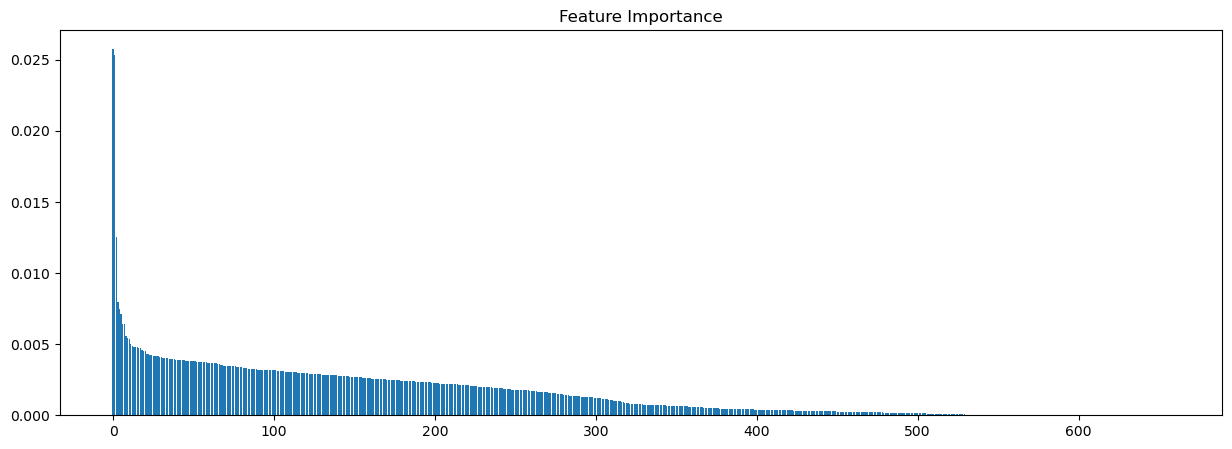

In [32]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
# Rearrange your features' names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create a plot
plt.figure(figsize=(15, 5))
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Show plot
plt.show()

#### Select the top features
##### As you can most of the features are useless. The first 15-20 features seems to be useful the most. Because of the lack enough datapoints (audio files), we chose to select fewer features (the top 4 features).

In [33]:
# Number of features to select
n_top_features = 4
# Selecting the top n features
top_extracted_features = names[:n_top_features]
np.save('top_extracted_features.npy', top_extracted_features)


# Creating a new DataFrame with only the top n features
X_train_selected = X_train[top_extracted_features]
X_test_selected = X_test[top_extracted_features]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.fit_transform(X_test_selected)

# Train a new model
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Evaluate the model
# Predict on the test set
y_pred = rf_selected.predict(X_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with the top {n_top_features} features: {accuracy:.2f}")

Accuracy with the top 4 features: 0.84


#### The chosen four features

In [34]:
top_extracted_features

['Tonnetz 6', 'Tonnetz 5', 'Percussive MFCC 11', 'Percussive MFCC 9']

#### Quick Model evalution (with top 4 features): Logistic Regression, Random Forest, and MLP

In [35]:
print("Logistic Regression:")
lr_model = LogisticRegression(max_iter=10000)
lr_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=10)  # 5-fold cross-validation
print("Logistic Regression Accuracy:", lr_scores.mean())

print("Random Forest:")
rf_model = RandomForestClassifier()
rf_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=10)
print("Random Forest Accuracy:", rf_scores.mean())

print("MLP:")
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 32), 
                          alpha=0.0001,  # L2 regularization term
                          max_iter=5000,   # Number of epochs
                          random_state=42)
cv_scores = cross_val_score(mlp_model, X_train_scaled, y_train, cv=5)
print("Average CV Accuracy:", cv_scores.mean())

Logistic Regression:
Logistic Regression Accuracy: 0.6157715260017051
Random Forest:
Random Forest Accuracy: 0.8385336743393008
MLP:
Average CV Accuracy: 0.832635142282873


#### Create a dataset with the top 4 extracted features

In [36]:
X = df1.drop('Chord Type', axis=1)
y = df1['Chord Type']

#### ----------------------------------------------------------------------------------------------------------------------------------------

### Spectrogram Analysis and Further Feature Extraction
##### We've consider doing a different kind of analysis and feature extraction through Spectrogram

In [37]:
# define a function that read audio files, applyie Fourier, and find peak frequencies
def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

#### Read the audio files again, pass them to the function 'find_harmonics', store the harmonics as columns, and create a Data Frame-type dataset

In [38]:
path = "./Audio_Files"
data = []
max_harm_length = 0 # i will keep track of max harmonic length for naming columns

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        # Only process .wav files
        if filename.endswith('.wav'):
            foldername = os.path.basename(dirname)
            full_path = os.path.join(dirname, filename)
            freq_peaks = find_harmonics(full_path)
        
            max_harm_length = max(max_harm_length, len(freq_peaks))
        
            cur_data = [foldername, filename]
            cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
            cur_data.extend(freq_peaks)
        
            data.append(cur_data)

# Column Names for DataFrame:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df2 = pd.DataFrame(data, columns=cols)
df2.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Major,Major_500.wav,116.82,2102.27,27,116.82,165.45,221.36,233.64,262.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Major,Major_266.wav,109.78,1949.33,26,109.78,165.33,220.00,247.11,278.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Major,Major_272.wav,109.78,1949.33,26,109.78,165.33,220.00,247.11,278.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Major,Major_299.wav,147.11,741.78,12,147.11,208.44,233.33,262.22,293.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_474.wav,116.89,1960.00,25,116.89,175.11,228.44,234.22,294.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate intervals between harmonics

In [39]:
for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df2[curr_interval] = df2[curr_harm].div(df2[prev_harm], axis=0)
    
df2.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Major,Major_500.wav,116.82,2102.27,27,116.82,165.45,221.36,233.64,262.27,...,1.264284,1.058943,1.121036,1.041574,1.007756,1.070417,1.121779,1.057726,1.054566,1.046403
1,Major,Major_266.wav,109.78,1949.33,26,109.78,165.33,220.00,247.11,278.22,...,1.187711,1.122396,1.040740,1.014974,1.054444,1.010227,1.185295,1.124893,1.040732,1.067923
2,Major,Major_272.wav,109.78,1949.33,26,109.78,165.33,220.00,247.11,278.22,...,1.187711,1.122396,1.040740,1.075415,1.005360,1.185295,1.124893,1.040732,1.067923,1.008263
3,Major,Major_299.wav,147.11,741.78,12,147.11,208.44,233.33,262.22,293.78,...,1.186222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Major,Major_474.wav,116.89,1960.00,25,116.89,175.11,228.44,234.22,294.67,...,1.192320,1.115118,1.046506,1.067207,1.010662,1.060309,1.120849,1.115858,1.005303,1.194876


#### Plot the intervals between the harmonics

/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/3731999732.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df2, x="Interval {}".format(i), hue="Chord Type", shade=True)
/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/3731999732.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df2, x="Interval {}".format(i), hue="Chord Type", shade=True)
/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/3731999732.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df2, x="Interval {}".format(i), hue="Chord Type", shade=True)
/var/folders/ps/bsyj9bqj7110t7m59qgl73l4000

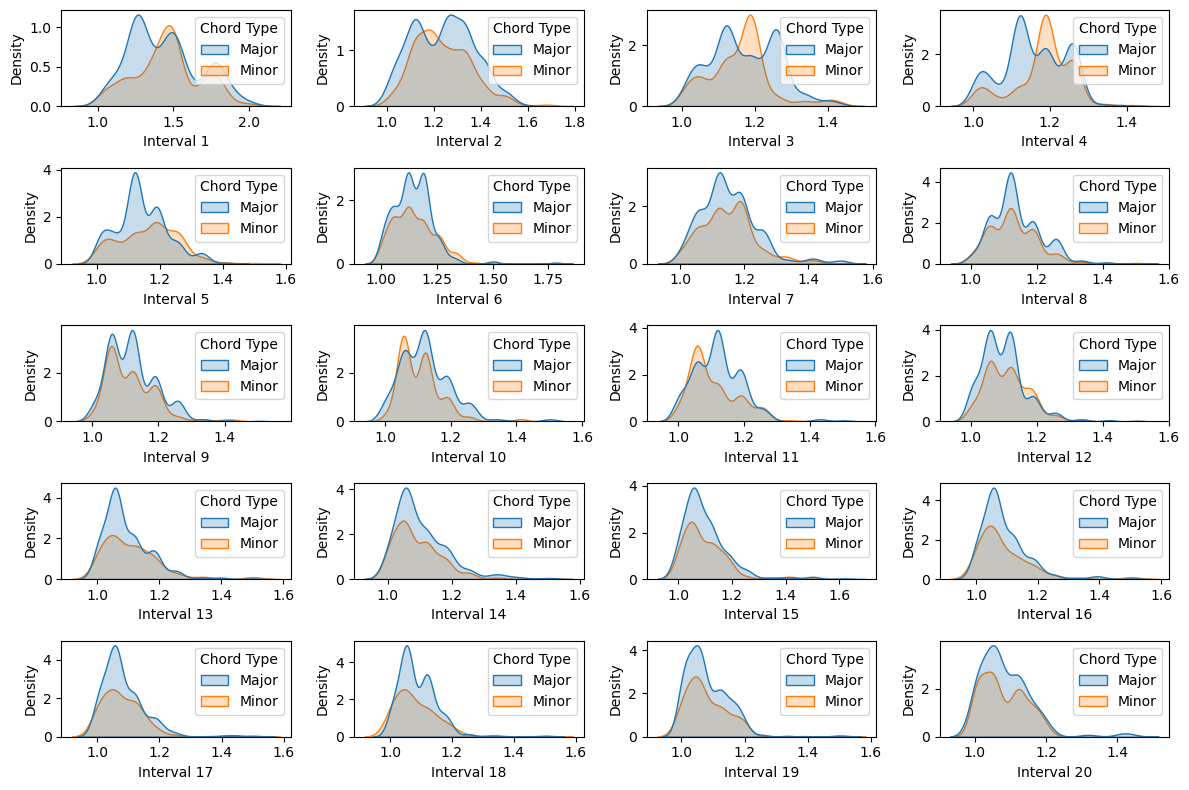

In [40]:
# Plot the intervals
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df2, x="Interval {}".format(i), hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

#### Calculate and plot the interval between the the first harmonic and the other harmonics

/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/3818271979.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df2, x=curr_interval, hue="Chord Type", shade=True)
/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/3818271979.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df2, x=curr_interval, hue="Chord Type", shade=True)
/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/3818271979.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df2, x=curr_interval, hue="Chord Type", shade=True)
/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/38182719

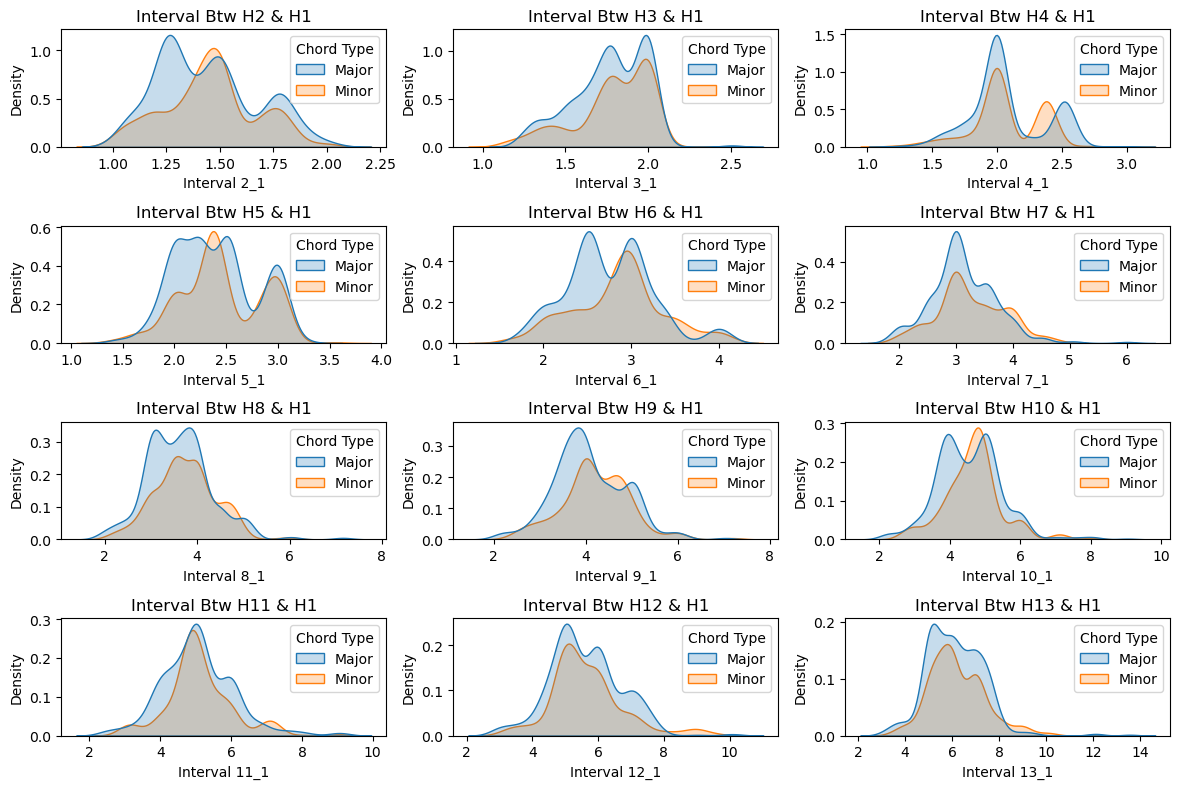

In [41]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df2[curr_interval] = df2[curr_harm].div(df2["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df2, x=curr_interval, hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

#### Combine the top 4 extracted features with the other four extracted features from spectrogram
##### As we can see that there are many intervals that would be useful as features, but because of lack of enough datapoints, we'll choose the four most useful intervals and there are 'interval 3', 'interval 4', 'interval 4_1', 'interval 5_1'.

### Final dataset (with eight features): 
#### Now, we'll combine the four (chosen) extracted spectrogram features with the other four features we extracted earlier.

In [42]:
df2["Chord Type"] = df2["Chord Type"].replace("Major", 1)
df2["Chord Type"] = df2["Chord Type"].replace("Minor", 0)

spectrogram_features = ["Interval 3", "Interval 4", "Interval 4_1", "Interval 5_1"]
spectrogram_columns = df2[spectrogram_features]

feature_extraction_columns = df1[top_extracted_features]

# Combine the features
combined_features = pd.concat([spectrogram_columns, feature_extraction_columns], axis=1)

In [43]:
combined_features.shape

(859, 8)

In [44]:
X = combined_features
y = df2['Chord Type'] 
print(X.shape, y.shape)

(859, 8) (859,)


#### Scale (or normalize) the dataset

In [45]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Split the dataset into train and test sets

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(687, 8) (687,) (172, 8) (172,)


#### Store the final extracted features

In [47]:
# # Save the processed data to files
# np.save('X_train.npy', X_train)
# np.save('X_test.npy', X_test)
# np.save('y_train.npy', y_train)
# np.save('y_test.npy', y_test)

#### Load the final extracted features

In [75]:
# Load the preprocessed data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [76]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(687, 8) (687,) (172, 8) (172,)


#### Quick Model evalution (with the combined features - 8 features): Using Cross-Validation on Logistic Regression, Random Forest, and MLP

In [50]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=5000)
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=10)
print("Logistic Regression Accuracy:", lr_scores.mean())

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=10)
print("Random Forest Accuracy:", rf_scores.mean())

# Multilayer Perceptron (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 32), 
                          alpha=0.0001,  # L2 regularization term
                          max_iter=1000,   # Number of epochs
                          random_state=42)
# Perform cross-validation
cv_scores = cross_val_score(mlp_model, X_train, y_train, cv=5)
print("MLP Accuracy:", cv_scores.mean())

Logistic Regression Accuracy: 0.636082693947144


Random Forest Accuracy: 0.9258525149190111
MLP Accuracy: 0.9039669946048873


### Train and evaluate different models on the dataset

#### Logistic Regression
##### 1) Perform a Grid Search of hyperparameters. 2) Find the best hyperparameters. 3) Use them train the Logistic Regression model. 4) Evaluate it on the test set

In [51]:
# Logistic Regression

# Define the model
lr_model = LogisticRegression()

# Define a grid of hyperparameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],  # Regularization strength
    'solver': ['lbfgs', 'sag', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [10000]  # Maximum number of iterations taken for the solvers to converge
}

# Setup the grid search
grid_search = GridSearchCV(lr_model, param_grid, cv=5, verbose=3)  # 5-fold cross-validation
# Train the model
grid_search.fit(X_train, y_train)
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
# Evaluate on the test set
y_pred = grid_search.predict(X_test)
# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END C=0.001, max_iter=10000, solver=lbfgs;, score=0.587 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=10000, solver=lbfgs;, score=0.587 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=10000, solver=lbfgs;, score=0.591 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=10000, solver=lbfgs;, score=0.591 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=10000, solver=lbfgs;, score=0.584 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=10000, solver=sag;, score=0.587 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=10000, solver=sag;, score=0.587 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=10000, solver=sag;, score=0.591 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=10000, solver=sag;, score=0.591 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=10000, solver=sag;, score=0.584 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=10000, solver=saga;, score=0.587 total time=   0.0s
[CV 2/5] END C=0.001, max_

##### Retrain the logistic regression model with the best hyperparameters and evaluate on the test set

Epoch 1, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 2, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 3, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 4, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 5, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 6, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 7, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 8, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 9, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 10, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 11, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 12, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 13, Train Loss: 0.64, Train Acc: 0.64, Test Loss: 0.70, Test Acc: 0.56
Epoch 14

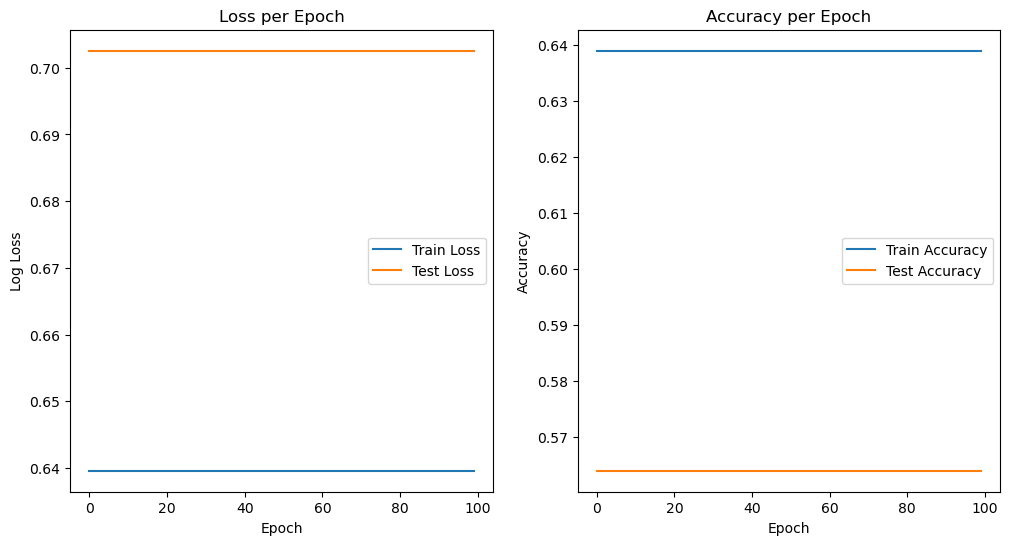

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.34      0.40        74
           1       0.60      0.73      0.66        98

    accuracy                           0.56       172
   macro avg       0.54      0.54      0.53       172
weighted avg       0.55      0.56      0.55       172



<Figure size 800x800 with 0 Axes>

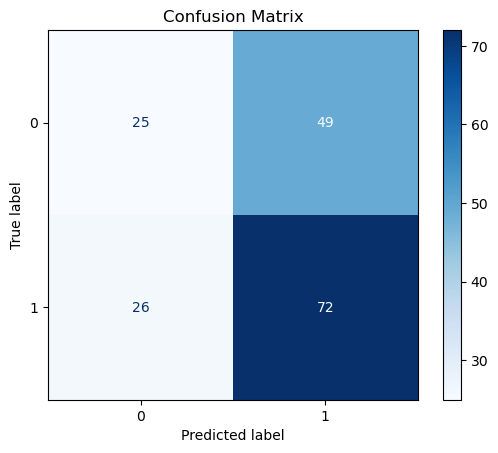

['logreg_model_weights.pkl']

In [52]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

num_epochs = 100  # Define the number of epochs
for epoch in range(num_epochs):
    # Create a new model instance for each epoch
    model = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
    
    # Fit the model
    model.fit(X_train, y_train)

    # Predict and calculate loss for the training set
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)
    train_loss = log_loss(y_train, y_train_pred_proba)
    train_losses.append(train_loss)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Predict and calculate loss for the test set
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)
    test_loss = log_loss(y_test, y_test_pred_proba)
    test_losses.append(test_loss)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.2f}, Train Acc: {train_accuracy:.2f}, Test Loss: {test_loss:.2f}, Test Acc: {test_accuracy:.2f}')

# Plotting loss and accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# You can also print a full classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
# And a confusion matrix

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d', cmap='Blues')  # 'd' for integer formatting
plt.title('Confusion Matrix')
plt.show()

# Save the model weights
joblib.dump(grid_search.best_estimator_.coef_, 'logreg_model_weights.pkl')

#### Random Forest
##### 1) Perform a Grid Search of hyperparameters. 2) Find the best hyperparameters. 3) Use them train the Logistic Regression model. 4) Evaluate it on the test set

In [53]:
# Random Forest

# Define the model
rf = RandomForestClassifier()

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]        # Whether bootstrap samples are used when building trees
}

# Setup the grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, verbose=3)  # 5-fold cross-validation

# Train the model
grid_search.fit(X_train, y_train)
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[CV 1/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.935 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.884 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.942 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.920 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.934 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.942 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.884 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=None, min

##### Retrain the random forest model with the best hyperparameters and evaluate on the test set

Train Accuracy: 1.00, Train Loss: 0.04
Test Accuracy: 0.91, Test Loss: 0.27
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89        74
           1       0.90      0.94      0.92        98

    accuracy                           0.91       172
   macro avg       0.91      0.90      0.90       172
weighted avg       0.91      0.91      0.91       172



<Figure size 800x800 with 0 Axes>

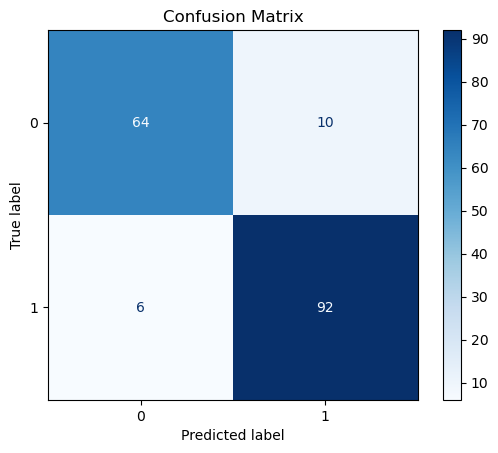

['rf_model.pkl']

In [54]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, bootstrap=False,
                                min_samples_split=2, min_samples_leaf=2, random_state=42)
model.fit(X_train, y_train)

# Calculate accuracy and log loss on the training set
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_loss = log_loss(y_train, y_train_proba)

# Evaluate on the test set
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_loss = log_loss(y_test, y_test_proba)

# Print metrics
print(f'Train Accuracy: {train_accuracy:.2f}, Train Loss: {train_loss:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}')

# Print a full classification report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Optionally save the model and parameters
joblib.dump(model, 'rf_model.pkl')

#### MLP model
##### 1) Perform a Grid Search of hyperparameters. 2) Find the best hyperparameters. 3) Use them train the Logistic Regression model. 4) Evaluate it on the test set

##### We perofrmed a GridSearch. It took a few hours to finish. We ran into a plotting issue that made the code fail but thankfully, the best hyperparameters were output after the GridSearch, so we were able to get (and save) the best hyperparameters out of the following GridSearch:
##### GridSearch of hyperparameters
###### param_grid = {
######    'hidden_layer_sizes': [(128, 32), (64, 32), (32, 32)],  # Different layer sizes
######    'activation': ['tanh', 'relu'],                         # Activation functions
######    'solver': ['adam', 'sgd'],                              # Solvers
######    'alpha': [0.00001, 0.0001],                             # L2 penalty (regularization term) parameter
######    'learning_rate': ['constant','adaptive'],               # Learning rate schedule for weight updates
######    'max_iter': [5000]                                      # Maximum number of iterations
###### }

##### Best hyperparameters: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (128, 32), 'learning_rate': 'constant', 'max_iter': 5000, 'solver': 'adam'}


##### Retrain the MLP model with the best hyperparameters and evaluate it on the test set

In [77]:
# Initialize MLPClassifier with the best hyperparameters
mlp = MLPClassifier(hidden_layer_sizes=(128, 32), activation='tanh', solver='adam', alpha=0.00001, learning_rate='constant', max_iter=10000, warm_start=True)

train_accuracies, test_accuracies = [], []
train_losses, test_losses = [], []

num_epochs = 125  # Set the number of epochs

for epoch in range(num_epochs):
    # Training on the training set
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))

    # Calculating training accuracy and loss
    y_train_pred = mlp.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_loss = log_loss(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Calculating test accuracy and loss
    y_test_pred = mlp.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_loss = log_loss(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}, Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}')

# Save the entire model
joblib.dump(mlp, 'mlp_model.pkl')

# # Load the model
# best_mlp = joblib.load('mlp_model.pkl')

# Plotting Training and Test Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Test Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Classification Report:\n", classification_report(y_test, y_test_pred))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Epoch [1/125], Train Loss: 14.85, Train Accuracy: 0.59, Test Loss: 15.93, Test Accuracy: 0.56
Epoch [2/125], Train Loss: 12.33, Train Accuracy: 0.66, Test Loss: 14.88, Test Accuracy: 0.59
Epoch [3/125], Train Loss: 12.49, Train Accuracy: 0.65, Test Loss: 15.09, Test Accuracy: 0.58
Epoch [4/125], Train Loss: 12.91, Train Accuracy: 0.64, Test Loss: 16.14, Test Accuracy: 0.55
Epoch [5/125], Train Loss: 12.96, Train Accuracy: 0.64, Test Loss: 15.09, Test Accuracy: 0.58
Epoch [6/125], Train Loss: 13.12, Train Accuracy: 0.64, Test Loss: 15.30, Test Accuracy: 0.58
Epoch [7/125], Train Loss: 12.85, Train Accuracy: 0.64, Test Loss: 15.51, Test Accuracy: 0.57
Epoch [8/125], Train Loss: 12.75, Train Accuracy: 0.65, Test Loss: 15.51, Test Accuracy: 0.57
Epoch [9/125], Train Loss: 12.43, Train Accuracy: 0.66, Test Loss: 15.30, Test Accuracy: 0.58
Epoch [10/125], Train Loss: 11.91, Train Accuracy: 0.67, Test Loss: 14.88, Test Accuracy: 0.59
Epoch [11/125], Train Loss: 12.12, Train Accuracy: 0.66, Te

##### Make sure y_train and y_test are numpy arrays

In [57]:
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()


#### Neural Network:
##### 1) Simple Neural network with two hidden layers (128, 32)  2) A 20% drop-out is added between the first hidden layer and the second hidden layer. Another 20% drop-out is added between the second hidden layer and the output layer. 3) ReLU is the activation function and sigmoid is the output activation function 4) lr=0.00001, L2y=0.000001

Epoch [1/8000], Train loss: 0.683, Train accuracy: 58.66, Test loss: 0.686, Test accuracy: 56.98
Epoch [2/8000], Train loss: 0.679, Train accuracy: 58.08, Test loss: 0.686, Test accuracy: 56.98
Epoch [3/8000], Train loss: 0.682, Train accuracy: 58.95, Test loss: 0.686, Test accuracy: 56.98
Epoch [4/8000], Train loss: 0.683, Train accuracy: 58.37, Test loss: 0.685, Test accuracy: 56.98
Epoch [5/8000], Train loss: 0.678, Train accuracy: 58.52, Test loss: 0.685, Test accuracy: 56.98
Epoch [6/8000], Train loss: 0.681, Train accuracy: 58.37, Test loss: 0.685, Test accuracy: 56.98
Epoch [7/8000], Train loss: 0.683, Train accuracy: 58.22, Test loss: 0.685, Test accuracy: 56.98
Epoch [8/8000], Train loss: 0.676, Train accuracy: 58.66, Test loss: 0.685, Test accuracy: 56.98
Epoch [9/8000], Train loss: 0.681, Train accuracy: 58.66, Test loss: 0.685, Test accuracy: 56.98
Epoch [10/8000], Train loss: 0.682, Train accuracy: 58.52, Test loss: 0.685, Test accuracy: 56.98
Epoch [11/8000], Train loss: 

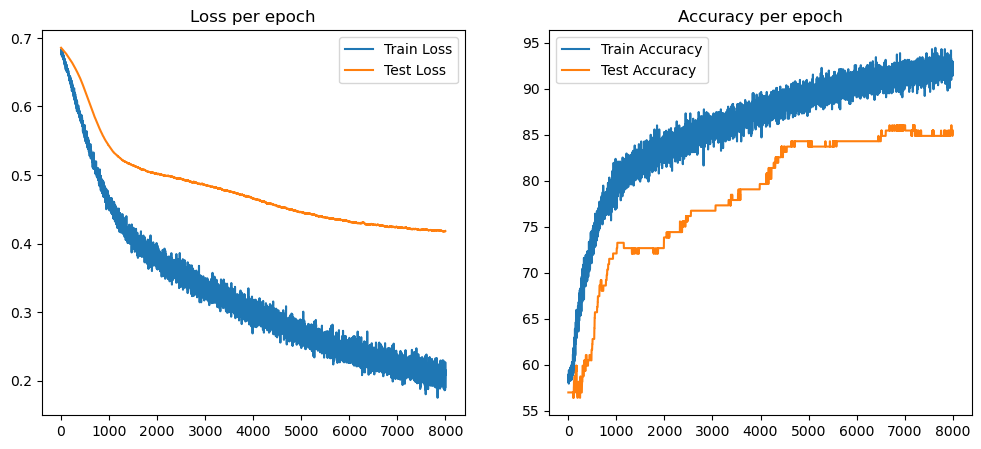

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        74
         1.0       0.83      0.93      0.88        98

    accuracy                           0.85       172
   macro avg       0.86      0.84      0.85       172
weighted avg       0.86      0.85      0.85       172



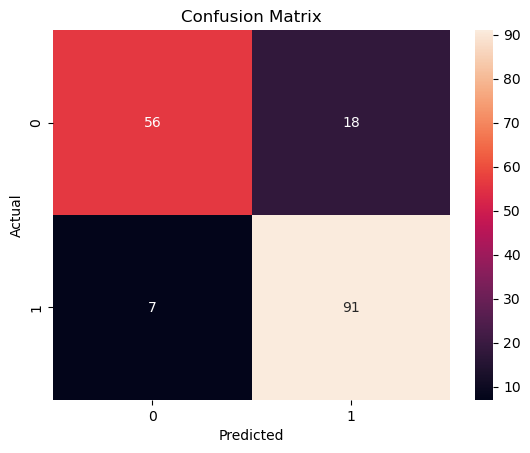

In [58]:
# Convert the dataset to tensor's dataset
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Define the neural network architecture
class ChordClassifier(nn.Module):
    def __init__(self):
        super(ChordClassifier, self).__init__()
        self.fc1 = nn.Linear(8, 128)  # 8 features as input
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x.view(-1)  # Flatten the output
    
# Initialize the model
model = ChordClassifier()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.000001)

# Training the model
num_epochs = 8000
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for inputs, labels in train_loader:
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs.data > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluating the model
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs.data > 0.5).float()
            test_loss += loss.item()
            predicted = (outputs.data > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss / len(train_loader):.3f}, Train accuracy: {train_accuracy:.2f}, Test loss: {test_loss / len(test_loader):.3f}, Test accuracy: {test_accuracy:.2f}')


# Save the model weights
torch.save(model.state_dict(), 'neural_network_weights.pth')

# To load the model weights later, you would use:
# model.load_state_dict(torch.load('chord_classifier_model_weights.pth'))
# model.eval()  # Make sure to call eval() for inference

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per epoch')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per epoch')
plt.legend()
plt.show()

# Classification Report and Confusion Matrix on Test Set
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.data > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

print("Classification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Simple CNN
##### 1) Simple Convulational Neural Network with two hidden layers (128, 32)  2) A 20% drop-out is added between the first hidden layer and the second hidden layer. Another 20% drop-out is added between the the second hidden layer and the output layer. 3) ReLU is the activation function and sigmoid is the output activation function 4) lr=0.00001, L2y=0.000001

Epoch [1/400], Train loss: 0.710, Train accuracy: 42.50, Test loss: 0.705, Test accuracy: 45.93
Epoch [2/400], Train loss: 0.704, Train accuracy: 46.00, Test loss: 0.699, Test accuracy: 45.93
Epoch [3/400], Train loss: 0.698, Train accuracy: 46.58, Test loss: 0.695, Test accuracy: 47.67


/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/2084782631.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/2084782631.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/var/folders/ps/bsyj9bqj7110t7m59qgl73l40000gn/T/ipykernel_78314/2084782631.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/va

Epoch [4/400], Train loss: 0.694, Train accuracy: 48.76, Test loss: 0.691, Test accuracy: 49.42
Epoch [5/400], Train loss: 0.689, Train accuracy: 53.86, Test loss: 0.688, Test accuracy: 52.91
Epoch [6/400], Train loss: 0.685, Train accuracy: 59.68, Test loss: 0.684, Test accuracy: 60.47
Epoch [7/400], Train loss: 0.682, Train accuracy: 63.32, Test loss: 0.682, Test accuracy: 61.05
Epoch [8/400], Train loss: 0.678, Train accuracy: 63.03, Test loss: 0.679, Test accuracy: 61.63
Epoch [9/400], Train loss: 0.675, Train accuracy: 64.05, Test loss: 0.677, Test accuracy: 61.63
Epoch [10/400], Train loss: 0.671, Train accuracy: 64.48, Test loss: 0.676, Test accuracy: 62.21
Epoch [11/400], Train loss: 0.668, Train accuracy: 65.21, Test loss: 0.674, Test accuracy: 62.79
Epoch [12/400], Train loss: 0.665, Train accuracy: 65.36, Test loss: 0.672, Test accuracy: 62.79
Epoch [13/400], Train loss: 0.662, Train accuracy: 65.07, Test loss: 0.670, Test accuracy: 61.63
Epoch [14/400], Train loss: 0.660, T

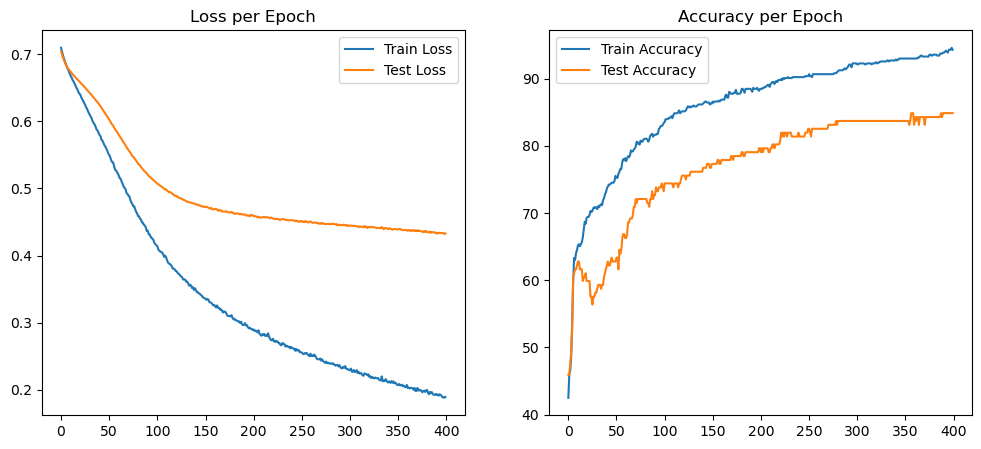

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.74      0.81        74
         1.0       0.83      0.93      0.87        98

    accuracy                           0.85       172
   macro avg       0.86      0.84      0.84       172
weighted avg       0.85      0.85      0.85       172



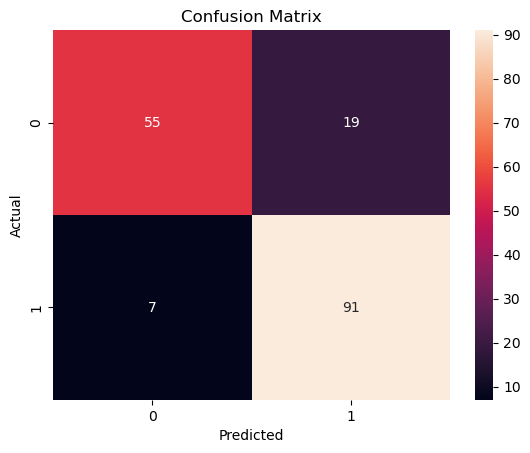

In [59]:
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape data for 1D CNN
# CNNs expect data in the format: (batch_size, channels, length)
# In your case, we can treat each feature as a channel
X_train = X_train.view(-1, 8, 1)  # Reshape to (batch_size, 8 channels, 1 length)
X_test = X_test.view(-1, 8, 1)

# Create PyTorch datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(8, 128, kernel_size=1)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 1)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x.view(-1)

# Initialize the model
model = SimpleCNN()

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.000001)

# Training the model
num_epochs = 400
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs.data > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluating the model
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs.data > 0.5).float()
            test_loss += loss.item()
            predicted = (outputs.data > 0.5).float()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss / len(train_loader):.3f}, Train accuracy: {train_accuracy:.2f}, Test loss: {test_loss / len(test_loader):.3f}, Test accuracy: {test_accuracy:.2f}')

# Save the model weights
torch.save(model.state_dict(), 'cnn_weights.pth')

# To load the model weights later, you would use:
# model.load_state_dict(torch.load('chord_classifier_model_weights.pth'))
# model.eval()  # Make sure to call eval() for inference

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

# Classification Report and Confusion Matrix on Test Set
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.data > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

print("Classification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Transformer

Dataset Creation and Preprocessing

In [73]:
dataset = load_dataset("audiofolder", data_dir="archive/Audio_Files/")
dataset = dataset["train"].train_test_split(test_size=0.15)
model_id = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)
dataset = dataset.cast_column("audio", Audio(sampling_rate=feature_extractor.sampling_rate))

max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

dataset_encoded = dataset.map(
    preprocess_function,
    remove_columns=["audio"],
    batched=True,
    batch_size=100,
    num_proc=1,
)
dataset_encoded

Model Creation

In [ ]:
id2label_fn = dataset["train"].features["label"].int2str
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(dataset_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

model_name = model_id.split("/")[-1]
batch_size = 8
gradient_accumulation_steps = 1
num_train_epochs = 40

training_args = TrainingArguments(
    f"{model_name}-finetuned-chordclassifier",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

trainer = Trainer(
    model,
    training_args,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['projector.bias', 'classifier.bias', 'projector.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▎         | 92/3680 [00:18<06:47,  8.81it/s]

{'eval_loss': 0.6642858386039734, 'eval_accuracy': 0.6434108527131783, 'eval_runtime': 2.0048, 'eval_samples_per_second': 64.345, 'eval_steps_per_second': 8.48, 'epoch': 1.0}


  3%|▎         | 101/3680 [00:20<12:31,  4.76it/s]

{'loss': 0.6858, 'learning_rate': 5.3260869565217395e-06, 'epoch': 1.09}


                                                  
  5%|▌         | 184/3680 [00:35<06:52,  8.47it/s]

{'eval_loss': 0.6529096364974976, 'eval_accuracy': 0.6434108527131783, 'eval_runtime': 2.088, 'eval_samples_per_second': 61.781, 'eval_steps_per_second': 8.142, 'epoch': 2.0}


  5%|▌         | 201/3680 [00:39<09:38,  6.01it/s]

{'loss': 0.6866, 'learning_rate': 1.0706521739130436e-05, 'epoch': 2.17}


                                                  
  8%|▊         | 276/3680 [00:53<06:22,  8.89it/s]

{'eval_loss': 0.6454831957817078, 'eval_accuracy': 0.6434108527131783, 'eval_runtime': 2.0776, 'eval_samples_per_second': 62.091, 'eval_steps_per_second': 8.183, 'epoch': 3.0}


  8%|▊         | 301/3680 [00:57<09:22,  6.01it/s]

{'loss': 0.6907, 'learning_rate': 1.614130434782609e-05, 'epoch': 3.26}


                                                  
 10%|█         | 368/3680 [01:11<06:34,  8.39it/s]

{'eval_loss': 0.6355680823326111, 'eval_accuracy': 0.6434108527131783, 'eval_runtime': 2.1897, 'eval_samples_per_second': 58.913, 'eval_steps_per_second': 7.764, 'epoch': 4.0}


 11%|█         | 401/3680 [01:16<09:15,  5.91it/s]

{'loss': 0.6723, 'learning_rate': 1.982487922705314e-05, 'epoch': 4.35}


                                                  
 12%|█▎        | 460/3680 [01:28<06:14,  8.59it/s]

{'eval_loss': 0.636027991771698, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.123, 'eval_samples_per_second': 60.763, 'eval_steps_per_second': 8.008, 'epoch': 5.0}


 14%|█▎        | 501/3680 [01:36<08:53,  5.96it/s]

{'loss': 0.6642, 'learning_rate': 1.9233091787439615e-05, 'epoch': 5.43}


                                                  
 15%|█▌        | 552/3680 [01:46<06:10,  8.44it/s]

{'eval_loss': 0.6300228834152222, 'eval_accuracy': 0.7131782945736435, 'eval_runtime': 2.2448, 'eval_samples_per_second': 57.466, 'eval_steps_per_second': 7.573, 'epoch': 6.0}


 16%|█▋        | 601/3680 [01:55<09:00,  5.70it/s]

{'loss': 0.6539, 'learning_rate': 1.8629227053140098e-05, 'epoch': 6.52}


                                                  
 18%|█▊        | 644/3680 [02:05<06:12,  8.14it/s]

{'eval_loss': 0.6331730484962463, 'eval_accuracy': 0.6744186046511628, 'eval_runtime': 2.3986, 'eval_samples_per_second': 53.781, 'eval_steps_per_second': 7.087, 'epoch': 7.0}


 19%|█▉        | 701/3680 [02:16<09:10,  5.42it/s]

{'loss': 0.6393, 'learning_rate': 1.802536231884058e-05, 'epoch': 7.61}


                                                  
 20%|██        | 736/3680 [02:24<06:03,  8.10it/s]

{'eval_loss': 0.606000542640686, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 2.1963, 'eval_samples_per_second': 58.734, 'eval_steps_per_second': 7.74, 'epoch': 8.0}


 22%|██▏       | 801/3680 [02:36<08:56,  5.37it/s]

{'loss': 0.6323, 'learning_rate': 1.742753623188406e-05, 'epoch': 8.7}


                                                  
 22%|██▎       | 828/3680 [02:43<06:05,  7.81it/s]

{'eval_loss': 0.5936762094497681, 'eval_accuracy': 0.7364341085271318, 'eval_runtime': 2.3049, 'eval_samples_per_second': 55.968, 'eval_steps_per_second': 7.376, 'epoch': 9.0}


 24%|██▍       | 901/3680 [02:57<08:24,  5.51it/s]

{'loss': 0.5906, 'learning_rate': 1.682367149758454e-05, 'epoch': 9.78}


                                                  
 25%|██▌       | 920/3680 [03:02<05:45,  7.98it/s]

{'eval_loss': 0.6035761833190918, 'eval_accuracy': 0.6821705426356589, 'eval_runtime': 2.2291, 'eval_samples_per_second': 57.872, 'eval_steps_per_second': 7.626, 'epoch': 10.0}


 27%|██▋       | 1001/3680 [03:17<08:09,  5.48it/s]

{'loss': 0.5404, 'learning_rate': 1.6219806763285028e-05, 'epoch': 10.87}


                                                   
 28%|██▊       | 1012/3680 [03:21<05:30,  8.07it/s]

{'eval_loss': 0.597490668296814, 'eval_accuracy': 0.7209302325581395, 'eval_runtime': 2.2101, 'eval_samples_per_second': 58.368, 'eval_steps_per_second': 7.692, 'epoch': 11.0}


 30%|██▉       | 1101/3680 [03:37<07:45,  5.54it/s]

{'loss': 0.471, 'learning_rate': 1.561594202898551e-05, 'epoch': 11.96}


                                                   
 30%|███       | 1104/3680 [03:40<05:28,  7.83it/s]

{'eval_loss': 0.6047921776771545, 'eval_accuracy': 0.7054263565891473, 'eval_runtime': 2.2815, 'eval_samples_per_second': 56.541, 'eval_steps_per_second': 7.451, 'epoch': 12.0}


                                                   
 32%|███▎      | 1196/3680 [03:59<05:23,  7.68it/s]

{'eval_loss': 0.643020749092102, 'eval_accuracy': 0.7131782945736435, 'eval_runtime': 2.3836, 'eval_samples_per_second': 54.12, 'eval_steps_per_second': 7.132, 'epoch': 13.0}


 33%|███▎      | 1201/3680 [04:01<15:43,  2.63it/s]

{'loss': 0.3642, 'learning_rate': 1.5012077294685991e-05, 'epoch': 13.04}


                                                   
 35%|███▌      | 1288/3680 [04:19<04:57,  8.05it/s]

{'eval_loss': 0.6692538261413574, 'eval_accuracy': 0.7364341085271318, 'eval_runtime': 2.2918, 'eval_samples_per_second': 56.289, 'eval_steps_per_second': 7.418, 'epoch': 14.0}


 35%|███▌      | 1301/3680 [04:22<07:42,  5.14it/s]

{'loss': 0.2732, 'learning_rate': 1.441425120772947e-05, 'epoch': 14.13}


                                                   
 38%|███▊      | 1380/3680 [04:38<04:55,  7.78it/s]

{'eval_loss': 0.7599384188652039, 'eval_accuracy': 0.7596899224806202, 'eval_runtime': 2.3499, 'eval_samples_per_second': 54.897, 'eval_steps_per_second': 7.234, 'epoch': 15.0}


 38%|███▊      | 1401/3680 [04:43<07:07,  5.33it/s]

{'loss': 0.1736, 'learning_rate': 1.3810386473429953e-05, 'epoch': 15.22}


                                                   
 40%|████      | 1472/3680 [04:58<04:45,  7.73it/s]

{'eval_loss': 0.8247535228729248, 'eval_accuracy': 0.7984496124031008, 'eval_runtime': 2.2961, 'eval_samples_per_second': 56.182, 'eval_steps_per_second': 7.404, 'epoch': 16.0}


 41%|████      | 1501/3680 [05:04<06:44,  5.39it/s]

{'loss': 0.1578, 'learning_rate': 1.3212560386473433e-05, 'epoch': 16.3}


                                                   
 42%|████▎     | 1564/3680 [05:18<04:34,  7.72it/s]

{'eval_loss': 1.2011154890060425, 'eval_accuracy': 0.7674418604651163, 'eval_runtime': 2.3464, 'eval_samples_per_second': 54.977, 'eval_steps_per_second': 7.245, 'epoch': 17.0}


 44%|████▎     | 1601/3680 [05:25<06:13,  5.57it/s]

{'loss': 0.0979, 'learning_rate': 1.261473429951691e-05, 'epoch': 17.39}


                                                   
 45%|████▌     | 1656/3680 [05:37<04:10,  8.07it/s]

{'eval_loss': 1.416422963142395, 'eval_accuracy': 0.7596899224806202, 'eval_runtime': 2.2871, 'eval_samples_per_second': 56.404, 'eval_steps_per_second': 7.433, 'epoch': 18.0}


 46%|████▌     | 1701/3680 [05:45<05:51,  5.62it/s]

{'loss': 0.0578, 'learning_rate': 1.2010869565217392e-05, 'epoch': 18.48}


                                                   
 48%|████▊     | 1748/3680 [05:56<04:01,  7.99it/s]

{'eval_loss': 1.3207558393478394, 'eval_accuracy': 0.7984496124031008, 'eval_runtime': 2.2349, 'eval_samples_per_second': 57.721, 'eval_steps_per_second': 7.607, 'epoch': 19.0}


 49%|████▉     | 1801/3680 [06:06<05:34,  5.62it/s]

{'loss': 0.043, 'learning_rate': 1.1407004830917876e-05, 'epoch': 19.57}


                                                   
 50%|█████     | 1840/3680 [06:15<03:49,  8.01it/s]

{'eval_loss': 1.4931979179382324, 'eval_accuracy': 0.7674418604651163, 'eval_runtime': 2.2479, 'eval_samples_per_second': 57.386, 'eval_steps_per_second': 7.562, 'epoch': 20.0}


 52%|█████▏    | 1901/3680 [06:26<05:22,  5.51it/s]

{'loss': 0.0408, 'learning_rate': 1.080314009661836e-05, 'epoch': 20.65}


                                                   
 52%|█████▎    | 1932/3680 [06:33<03:39,  7.96it/s]

{'eval_loss': 1.5491734743118286, 'eval_accuracy': 0.7751937984496124, 'eval_runtime': 2.2915, 'eval_samples_per_second': 56.296, 'eval_steps_per_second': 7.419, 'epoch': 21.0}


 54%|█████▍    | 2001/3680 [06:46<04:49,  5.80it/s]

{'loss': 0.0175, 'learning_rate': 1.0199275362318842e-05, 'epoch': 21.74}


                                                   
 55%|█████▌    | 2024/3680 [06:52<03:16,  8.43it/s]

{'eval_loss': 1.369537591934204, 'eval_accuracy': 0.813953488372093, 'eval_runtime': 2.2193, 'eval_samples_per_second': 58.126, 'eval_steps_per_second': 7.66, 'epoch': 22.0}


 57%|█████▋    | 2101/3680 [07:06<04:37,  5.69it/s]

{'loss': 0.0436, 'learning_rate': 9.595410628019325e-06, 'epoch': 22.83}


                                                   
 57%|█████▊    | 2116/3680 [07:11<03:10,  8.19it/s]

{'eval_loss': 1.5184537172317505, 'eval_accuracy': 0.7751937984496124, 'eval_runtime': 2.2305, 'eval_samples_per_second': 57.835, 'eval_steps_per_second': 7.622, 'epoch': 23.0}


 60%|█████▉    | 2201/3680 [07:26<04:20,  5.68it/s]

{'loss': 0.0141, 'learning_rate': 8.991545893719807e-06, 'epoch': 23.91}


                                                   
 60%|██████    | 2208/3680 [07:30<02:59,  8.21it/s]

{'eval_loss': 1.5884608030319214, 'eval_accuracy': 0.7829457364341085, 'eval_runtime': 2.2674, 'eval_samples_per_second': 56.894, 'eval_steps_per_second': 7.498, 'epoch': 24.0}


 62%|██████▎   | 2300/3680 [07:46<02:47,  8.22it/s]

{'loss': 0.0206, 'learning_rate': 8.38768115942029e-06, 'epoch': 25.0}


                                                   
 62%|██████▎   | 2300/3680 [07:49<02:47,  8.22it/s]

{'eval_loss': 1.5241628885269165, 'eval_accuracy': 0.8217054263565892, 'eval_runtime': 2.2323, 'eval_samples_per_second': 57.787, 'eval_steps_per_second': 7.615, 'epoch': 25.0}


                                                   
 65%|██████▌   | 2392/3680 [08:07<02:29,  8.60it/s]

{'eval_loss': 1.8800785541534424, 'eval_accuracy': 0.7286821705426356, 'eval_runtime': 2.1618, 'eval_samples_per_second': 59.672, 'eval_steps_per_second': 7.864, 'epoch': 26.0}


 65%|██████▌   | 2401/3680 [08:09<04:38,  4.59it/s]

{'loss': 0.0181, 'learning_rate': 7.783816425120773e-06, 'epoch': 26.09}


                                                   
 68%|██████▊   | 2484/3680 [08:26<02:25,  8.24it/s]

{'eval_loss': 1.604827642440796, 'eval_accuracy': 0.7984496124031008, 'eval_runtime': 2.2102, 'eval_samples_per_second': 58.366, 'eval_steps_per_second': 7.692, 'epoch': 27.0}


 68%|██████▊   | 2501/3680 [08:29<03:38,  5.40it/s]

{'loss': 0.0282, 'learning_rate': 7.179951690821257e-06, 'epoch': 27.17}


                                                   
 70%|███████   | 2576/3680 [08:45<02:16,  8.11it/s]

{'eval_loss': 1.7774361371994019, 'eval_accuracy': 0.7829457364341085, 'eval_runtime': 2.2086, 'eval_samples_per_second': 58.408, 'eval_steps_per_second': 7.697, 'epoch': 28.0}


 71%|███████   | 2601/3680 [08:50<03:13,  5.57it/s]

{'loss': 0.0168, 'learning_rate': 6.57608695652174e-06, 'epoch': 28.26}


                                                   
 72%|███████▎  | 2668/3680 [09:04<02:07,  7.97it/s]

{'eval_loss': 1.7530633211135864, 'eval_accuracy': 0.7751937984496124, 'eval_runtime': 2.2974, 'eval_samples_per_second': 56.149, 'eval_steps_per_second': 7.4, 'epoch': 29.0}


 73%|███████▎  | 2701/3680 [09:10<02:58,  5.49it/s]

{'loss': 0.0181, 'learning_rate': 5.972222222222222e-06, 'epoch': 29.35}


                                                   
 75%|███████▌  | 2760/3680 [09:23<01:55,  7.99it/s]

{'eval_loss': 1.6456400156021118, 'eval_accuracy': 0.7984496124031008, 'eval_runtime': 2.1947, 'eval_samples_per_second': 58.777, 'eval_steps_per_second': 7.746, 'epoch': 30.0}


 76%|███████▌  | 2801/3680 [09:30<02:35,  5.65it/s]

{'loss': 0.015, 'learning_rate': 5.368357487922707e-06, 'epoch': 30.43}


                                                   
 78%|███████▊  | 2852/3680 [09:41<01:41,  8.15it/s]

{'eval_loss': 1.8085957765579224, 'eval_accuracy': 0.7674418604651163, 'eval_runtime': 2.2603, 'eval_samples_per_second': 57.072, 'eval_steps_per_second': 7.521, 'epoch': 31.0}


 79%|███████▉  | 2901/3680 [09:51<02:20,  5.53it/s]

{'loss': 0.0208, 'learning_rate': 4.7644927536231886e-06, 'epoch': 31.52}


                                                   
 80%|████████  | 2944/3680 [10:00<01:31,  8.03it/s]

{'eval_loss': 1.7097631692886353, 'eval_accuracy': 0.7829457364341085, 'eval_runtime': 2.2517, 'eval_samples_per_second': 57.289, 'eval_steps_per_second': 7.55, 'epoch': 32.0}


 82%|████████▏ | 3001/3680 [10:11<02:04,  5.48it/s]

{'loss': 0.0089, 'learning_rate': 4.166666666666667e-06, 'epoch': 32.61}


                                                   
 82%|████████▎ | 3036/3680 [10:20<01:20,  7.98it/s]

{'eval_loss': 1.6887662410736084, 'eval_accuracy': 0.7906976744186046, 'eval_runtime': 2.2632, 'eval_samples_per_second': 56.998, 'eval_steps_per_second': 7.511, 'epoch': 33.0}


 84%|████████▍ | 3101/3680 [10:32<01:44,  5.56it/s]

{'loss': 0.0216, 'learning_rate': 3.5628019323671496e-06, 'epoch': 33.7}


                                                   
 85%|████████▌ | 3128/3680 [10:39<01:08,  8.03it/s]

{'eval_loss': 1.7992175817489624, 'eval_accuracy': 0.7674418604651163, 'eval_runtime': 2.2564, 'eval_samples_per_second': 57.171, 'eval_steps_per_second': 7.534, 'epoch': 34.0}


 87%|████████▋ | 3201/3680 [10:52<01:22,  5.81it/s]

{'loss': 0.015, 'learning_rate': 2.958937198067633e-06, 'epoch': 34.78}


                                                   
 88%|████████▊ | 3220/3680 [10:57<00:55,  8.21it/s]

{'eval_loss': 1.7710013389587402, 'eval_accuracy': 0.7674418604651163, 'eval_runtime': 2.2892, 'eval_samples_per_second': 56.352, 'eval_steps_per_second': 7.426, 'epoch': 35.0}


 90%|████████▉ | 3301/3680 [11:12<01:10,  5.39it/s]

{'loss': 0.0154, 'learning_rate': 2.355072463768116e-06, 'epoch': 35.87}


                                                   
 90%|█████████ | 3312/3680 [11:16<00:45,  8.06it/s]

{'eval_loss': 1.8340173959732056, 'eval_accuracy': 0.7751937984496124, 'eval_runtime': 2.2325, 'eval_samples_per_second': 57.784, 'eval_steps_per_second': 7.615, 'epoch': 36.0}


 92%|█████████▏| 3401/3680 [11:32<00:49,  5.65it/s]

{'loss': 0.0143, 'learning_rate': 1.7512077294685992e-06, 'epoch': 36.96}


                                                   
 92%|█████████▎| 3404/3680 [11:35<00:34,  8.09it/s]

{'eval_loss': 1.804334044456482, 'eval_accuracy': 0.7596899224806202, 'eval_runtime': 2.3075, 'eval_samples_per_second': 55.905, 'eval_steps_per_second': 7.367, 'epoch': 37.0}


                                                   
 95%|█████████▌| 3496/3680 [11:54<00:22,  8.32it/s]

{'eval_loss': 1.7682762145996094, 'eval_accuracy': 0.7596899224806202, 'eval_runtime': 2.1898, 'eval_samples_per_second': 58.91, 'eval_steps_per_second': 7.763, 'epoch': 38.0}


 95%|█████████▌| 3501/3680 [11:55<01:01,  2.89it/s]

{'loss': 0.0141, 'learning_rate': 1.1473429951690822e-06, 'epoch': 38.04}


                                                   
 98%|█████████▊| 3588/3680 [12:13<00:11,  7.99it/s]

{'eval_loss': 1.7799888849258423, 'eval_accuracy': 0.7596899224806202, 'eval_runtime': 2.2478, 'eval_samples_per_second': 57.39, 'eval_steps_per_second': 7.563, 'epoch': 39.0}


 98%|█████████▊| 3601/3680 [12:16<00:14,  5.31it/s]

{'loss': 0.0136, 'learning_rate': 5.434782608695653e-07, 'epoch': 39.13}


                                                   
100%|██████████| 3680/3680 [12:32<00:00,  8.03it/s]

{'eval_loss': 1.777160406112671, 'eval_accuracy': 0.7596899224806202, 'eval_runtime': 2.2871, 'eval_samples_per_second': 56.403, 'eval_steps_per_second': 7.433, 'epoch': 40.0}


100%|██████████| 3680/3680 [12:32<00:00,  4.89it/s]

{'train_runtime': 752.6249, 'train_samples_per_second': 38.798, 'train_steps_per_second': 4.89, 'train_loss': 0.22999679818749427, 'epoch': 40.0}


TrainOutput(global_step=3680, training_loss=0.22999679818749427, metrics={'train_runtime': 752.6249, 'train_samples_per_second': 38.798, 'train_steps_per_second': 4.89, 'train_loss': 0.22999679818749427, 'epoch': 40.0})

Prediction and Results

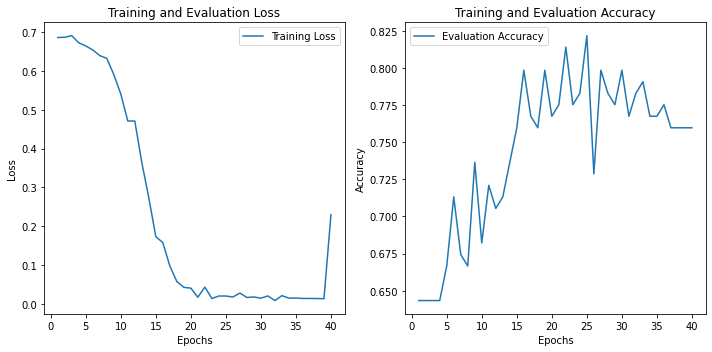

In [ ]:
train_loss = []
eval_loss = []
eval_accuracy = []
flag=0
for i,dic in enumerate(trainer.state.log_history):
    if "loss" in dic:
        if flag==1:
            flag=0
        train_loss.append(dic["loss"])
    elif "eval_loss" in dic:
        if flag == 0:
            flag = 1
        else:
            train_loss.append(train_loss[-1])
        eval_loss.append(dic["eval_loss"])
        eval_accuracy.append(dic["eval_accuracy"])
    elif "train_loss" in dic:
        train_loss.append(dic["train_loss"])

epochs = range(1, len(train_loss) + 1)



plt.figure(figsize=(10, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.title('Training and Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_accuracy, label='Evaluation Accuracy')
plt.title('Training and Evaluation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_outputs = trainer.predict(dataset_encoded["test"])
predictions = np.argmax(test_outputs.predictions, axis=1)
labels = test_outputs.label_ids
print("Classification Report:\n", classification_report(labels, predictions))

100%|██████████| 17/17 [00:01<00:00,  8.59it/s]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86        83
           1       0.76      0.74      0.75        46

    accuracy                           0.82       129
   macro avg       0.81      0.80      0.80       129
weighted avg       0.82      0.82      0.82       129



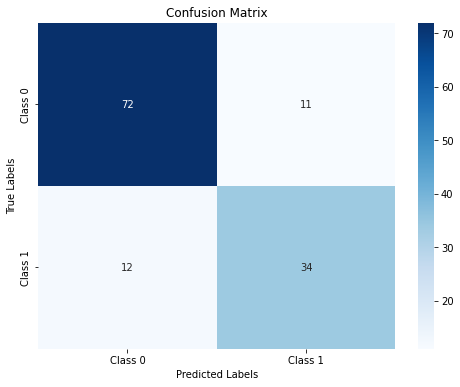

In [ ]:
cm = confusion_matrix(labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()